# How to use the catalog

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jbbutler/ar-catalog-demo/HEAD?urlpath=%2Fdoc%2Ftree%2F%2Fnotebook_files%2Fcatalog_tutorial.ipynb)

To follow along with this tutorial interactively, you can either clone [this repository](https://github.com/jbbutler/AR-Catalog-Tutorial) and follow the provided instructions to run the `catalog_tutorial.ipynb` notebook, or directly access a cloud-hosted Jupyter notebook by clicking the above Binder button (with the necessary conda environment set up automatically for you!). Note that if you clone the repository yourself, the `environment.yml` file found in the repository is crucial to loading up these hdf5 files; otherwise you may run into package conflicts.

In this tutorial, we will showcase both the catalog structure, and provide some examples of how you can take advantage of the `pandas.DataFrame` format to fill in desired info for each AR, with ease!

## Catalog Structure

In [23]:
import pandas as pd
import xarray as xr
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from notebook_files.catalog_display import display_catalog

The catalog files are organized by year, from 1980 until 2022. For this tutorial, we only look at the 2022 data. Each year's file is an .hdf5 file, that, once loaded, consists of a `pandas.DataFrame`. Let's load up the storms from 2022, and take a look at the output.

In [24]:
storms = pd.read_hdf('./notebook_files/2022_storm_df.h5')

Each row consists of an AR storm event.

There are two columns in the dataframe, `data_array` and `is_landfalling`. 

+ `data_array` is a binary mask for that particular AR event in that row, in the form of an xArray DataArray
+ `is_landfalling` indicates whether that storm ever makes landfall over the Antarctic ice sheet

First, let's display the catalog using the custom `display_catalog` function. This function behaves like `DataFrame.head()`, which shows the first $n$ many rows of the DataFrame, where in the `data_array` column we specifically show thumbnails of the footprint of the storm at the time of its greatest spatial extent (instead of showing a string representation of an `xarray.DataArray`, yuck!)

In [25]:
# don't run this, it will take a while and spit out gibberish!
# storms.head(10)

,data_array,is_landfalling
cluster,,
1.0,,True
2.0,,False
3.0,,True
4.0,,False
5.0,,False
7.0,,True
8.0,,True
9.0,,True
10.0,,False

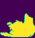
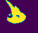
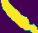
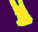

In [26]:
display_catalog(storms, 10)

Let's look at one of these DataArrays.. For instance, the AR that caused the 2022 Antarctic Heatwave..

In [12]:
storms.data_array.iloc[36]

<xarray.DataArray 'clust' (time: 38, lat: 93, lon: 253)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-13T15:00:00 ... 2022-03-18T06:00:00
  * lat      (lat) float64 -85.0 -84.5 -84.0 -83.5 ... -40.5 -40.0 -39.5 -39.0
  * lon      (lon) float64 -3.125 -2.5 -1.875 -1.25 ... 152.5 153.1 153.8 154.4

Let's look at a visualization of this storm's footprint, at a particular point in time.

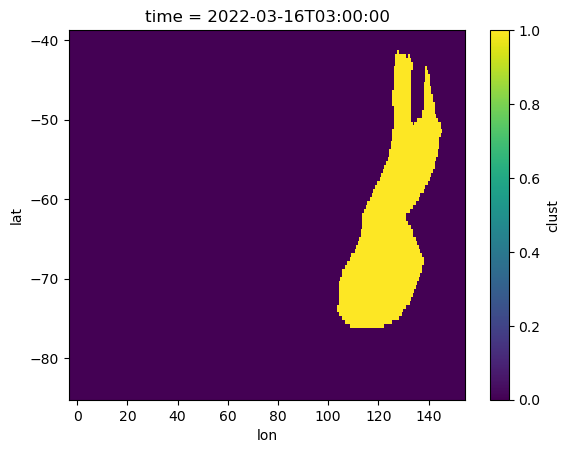

In [13]:
storms.data_array.iloc[36].isel(time=20).plot.imshow();

What if we just want to look at landfalling storms?

,data_array,is_landfalling
cluster,,
1.0,,True
3.0,,True
7.0,,True
8.0,,True
9.0,,True
13.0,,True
16.0,,True
17.0,,True
20.0,,True

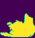
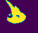
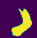
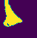

In [14]:
# first 20 storms of landfalling storms of 2022
display_catalog(storms[storms.is_landfalling], 10)

In [15]:
# input to display_catalog must always be a dataframe, no series!
display_catalog(storms.iloc[[100]], 20)

,data_array,is_landfalling
cluster,,
102.0,,True


## What can we do with such a catalog?

### 1. Get start, end dates, and total storm duration

In [16]:
def compute_duration(ar_da):
    days = (ar_da.time.max() - ar_da.time.min()).values.astype('timedelta64[h]').astype(int) + np.timedelta64(3, 'h')
    return days

def add_start_date(ar_da):
    start = ar_da.time.min().values
    return start

def add_end_date(ar_da):
    end = ar_da.time.max().values
    return end

In [17]:
storms['duration'] = storms['data_array'].apply(compute_duration)
storms['start_date'] = storms['data_array'].apply(add_start_date)
storms['end_date'] = storms['data_array'].apply(add_end_date)

,data_array,is_landfalling,duration,start_date,end_date
cluster,,,,,
1.0,,True,1 days 15:00:00,2022-01-01 00:00:00,2022-01-02 12:00:00
2.0,,False,0 days 06:00:00,2022-01-01 03:00:00,2022-01-01 06:00:00
3.0,,True,1 days 18:00:00,2022-01-04 15:00:00,2022-01-06 06:00:00
4.0,,False,0 days 12:00:00,2022-01-06 21:00:00,2022-01-07 06:00:00
5.0,,False,0 days 03:00:00,2022-01-08 06:00:00,2022-01-08 06:00:00
7.0,,True,2 days 06:00:00,2022-01-10 03:00:00,2022-01-12 06:00:00
8.0,,True,3 days 09:00:00,2022-01-13 09:00:00,2022-01-16 15:00:00
9.0,,True,2 days 18:00:00,2022-01-14 21:00:00,2022-01-17 12:00:00
10.0,,False,1 days 00:00:00,2022-01-16 15:00:00,2022-01-17 12:00:00

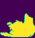
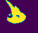
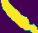
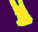

In [18]:
display_catalog(storms, 10)

### 2. Get storm areas

In [20]:
# compute maximum spatial extent of each storm in its lifetime

# grab area file
grid_areas = xr.open_dataset('./notebook_files/MERRA2_gridarea.nc')
grid_areas = grid_areas.sel(lat=slice(-86, -39)).cell_area

def compute_max_area(ar_da):
    grid_area_storm = grid_areas.sel(lat=ar_da.lat, lon=ar_da.lon)
    max_area = float(ar_da.dot(grid_area_storm).max().values/(1000**2))
    return max_area

In [21]:
storms['max_area'] = storms['data_array'].apply(compute_max_area)

,data_array,is_landfalling,duration,start_date,end_date,max_area
cluster,,,,,,
1.0,,True,1 days 15:00:00,2022-01-01 00:00:00,2022-01-02 12:00:00,2754999.129926
2.0,,False,0 days 06:00:00,2022-01-01 03:00:00,2022-01-01 06:00:00,55912.547547
3.0,,True,1 days 18:00:00,2022-01-04 15:00:00,2022-01-06 06:00:00,2034152.564619
4.0,,False,0 days 12:00:00,2022-01-06 21:00:00,2022-01-07 06:00:00,1371171.064538
5.0,,False,0 days 03:00:00,2022-01-08 06:00:00,2022-01-08 06:00:00,1516092.395778
7.0,,True,2 days 06:00:00,2022-01-10 03:00:00,2022-01-12 06:00:00,1359232.053438
8.0,,True,3 days 09:00:00,2022-01-13 09:00:00,2022-01-16 15:00:00,2841795.565555
9.0,,True,2 days 18:00:00,2022-01-14 21:00:00,2022-01-17 12:00:00,2846762.714167
10.0,,False,1 days 00:00:00,2022-01-16 15:00:00,2022-01-17 12:00:00,625818.053744

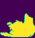
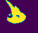
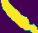
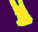

In [22]:
display_catalog(storms, 10)

### 3. Get any quantity you want from your favorite re-analysis product!

Each storm has an associated xarray mask in space and time.. use it to extract quantities from a reanalysis dataset of interest!